## PCA with PyKrev

* In this guide we will cover how to perform PCA on your FT-MS data using the sklearn (sci-kit learn) library and PyKrev.  PCA is a dimensionality reduction technique which projects your data onto a smaller subset of axis (known as principal components) whilst preserving maximum variance.
In this guide we will cover: 
 * Data Preparation 
 * Scree and variance plots
 * 2D PCA plots
 * Loading plots

In [38]:
from sklearn.decomposition import PCA #if you do not already have the library installed run 'pip install scikit-learn'
import pykrev as pk
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

* First we need to load in our dataset. In this example we are going to load in a batch aligned dataset. ```read_batch_formularity``` can then compute an ordination matrix directly on the data.
  * The dataset was taken from [Kew, Will, et al. (2018)](https://pubs.acs.org/doi/10.1021/acs.analchem.8b01446) and consists of four whisky samples (samples A - D) analysed using ESI mode FT-MS with formula assignment rules of O>0, N<2, S<=2, P<1.

In [39]:
fdata, fordination = pk.read_batch_formularity('batch_formularity.csv', impute_value = 0)
nsample, nformula = fordination.shape #the ordination matrix has samples in rows and formula in columns

Warning, duplicate formula assignments detected. Ordination matrix will report values for first formula it encounters.


* We should transpose the ordination matrix, so that the samples names are the column headers and the formula the rows in order to compute relative intensity. We can then compute relative intensity (sum normalised) calculations on the columns of this matrix using ```relative_intensity```. 
  * An important caveat: sum-normalised relative intensity calculations on FT-MS data is limited by the fact that FT-MS is not a quantitative technique, and the peak intensities of the formula in a sample are indicative of ionisation efficiency as well as the relative abundance of that formula. By making relative intensity calculations we are effectively treating the data as quantitiative and biasing our analysis against formula that do not efficiently ionize.  
  * If you would like to avoid making relative intensity calculations on your data, you can process the ordination matrix as a binary matrix, which indicates the presence or absence of a formula (1 or 0) but does not contain information about its abundance. I've provided a function ```binary_matrix``` that will convert an ordination matrix into this format. You can perform PCA on a binary matrix, but [it's not without it's own caveats](https://stats.stackexchange.com/questions/16331/doing-principal-component-analysis-or-factor-analysis-on-binary-data). 
  * In this example we will continue to use relative intensities. 

In [34]:
rordination = pk.relative_intensity(fordination.T)

In [46]:
def binary_matrix(ordination):
    """ This function converts an ordination matrix into a binary matrix."""
    bordination = ordination.copy()
    for idx in bordination.index:
        bordination.loc[idx][bordination.loc[idx] > 0] = 1
    return bordination
bordination = binary_matrix(fordination) # no need to transpose!

* Make sure to re-transpose the data back (so that sample names are rows and formula are column headers) prior to performing PCA.
  * If you used the ```binary_matrix``` function the data is already in the right format.

In [4]:
pordination = rordination.T
assert pordination.shape == (nsample,nformula)

* Now we are ready to perform PCA using the [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) library. PCA is performed by computing the eigenvectors of the covariance matrix of our dataset. The eigenvalues of each of these vectors explain how much of the variance was captured by their eigenvector. The PCA class within the sklearn library allows you to modify the method used to perform the eigendecomposition and change the number of components to keep. We are going to use the default parameters in which all principal components are kept.

In [5]:
pca = PCA() #instance of the PCA class, here we can define parameters about the PCA 
pca.fit(pordination) #fit the PCA intialised with default parameters to our data
pca_result = pca.transform(pordination) # transform our data with the fitted model
#print(pca_result) #print the coordinates of the PCA components in reduced dimensional space
#print(pca.explained_variance_ratio_) #print the relative contributions of the data 

* One way to visualise the variance explained by your principal coordinates is with a scree plot and a variance plot. You can use the ```scree_plot``` and ```variance_plot``` functions i've defined below to do this. 

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Principal Component', ylabel='Variance explained '>)

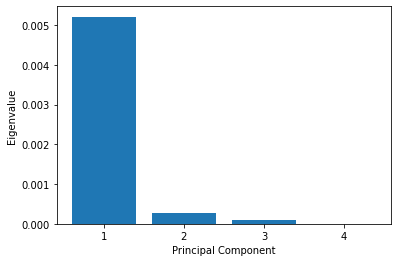

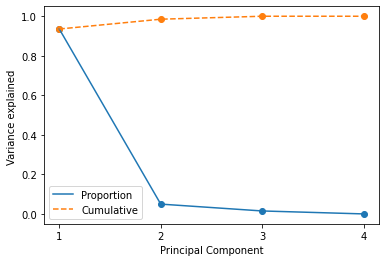

In [21]:
def scree_plot(pca_instance, **kwargs):
    """ This function creates a scree plot on the results of the sklearn implementation of PCA."""
    varExplained = pca_instance.explained_variance_ 
    componentN  = np.arange(1,len(varExplained)+1)
    plt.bar(componentN,varExplained, **kwargs)
    plt.xticks(componentN)
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    return plt.gcf(), plt.gca()

plt.figure()
scree_plot(pca)

def variance_plot(pca_instance, **kwargs):
    """ This function creates a variance plot on the results of the sklearn implementation of PCA."""
    varExplained = pca_instance.explained_variance_ratio_
    cumVarExplained = np.cumsum(pca_instance.explained_variance_ratio_)
    componentN  = np.arange(1,len(varExplained)+1)
    plt.scatter(componentN,varExplained)
    plt.plot(componentN,varExplained, linestyle = '-', **kwargs)
    plt.scatter(componentN,cumVarExplained)
    plt.plot(componentN,cumVarExplained, linestyle = '--',**kwargs)
    plt.xticks(componentN)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance explained ')
    plt.legend(['Proportion','Cumulative'])
    return plt.gcf(), plt.gca()   

plt.figure()
variance_plot(pca)

* So the first principal component explains ~94% of variation in the dataset, and the second ~5%. Let's plot the data, to do this we will use the ```pca_plot``` function which is defined below.

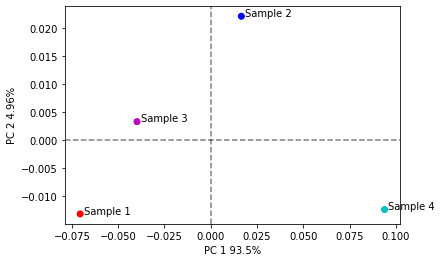

In [7]:
def pca_plot(pca_result, pca_instance, group_names = [], text_offset = 0.002, **kwargs):
    """ This function creates a 2D PCA plot on the results of the sklearn implementation of PCA."""
    varExplained = pca_instance.explained_variance_ratio_
    plt.scatter(pca_result[:,0],pca_result[:,1], **kwargs)
    plt.xlabel(f"PC 1 {str(varExplained[0]*100)[:4]}%")
    plt.ylabel(f"PC 2 {str(varExplained[1]*100)[:4]}%")
    ## add axis lines (like abline in r )
    plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
    plt.axvline(0, color='k', linestyle = '--', alpha = 0.5)
    if group_names:
        assert len(group_names)==len(pca_result[:,1])
        for i in range (0,len(group_names)):
            plt.text(pca_result[i,0] + text_offset,pca_result[i,1], group_names[i])
    return plt.gcf(), plt.gca() 

fig, ax = pca_plot(pca_result = pca_result, pca_instance = pca, 
         group_names = ['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4'],
         c = ['r','b','m','c'])

* The PCA plot is useful to visualise the separation between our samples, but how do the features of our dataset (in this case the molecular formula) contribute to this separation? To visualise this we will use plot the loadings of our features using ```loading_plot```.
 * First we need to extract the loadings and label them by their corresponding molecular formula. 

In [8]:
formula = list(fordination.columns) #extract the column headers from the ordination matrix 
loadings = pca.components_.T #extract the loadings of the formula 
loadingDF= pd.DataFrame(loadings,formula) #this constructs a dataframe with the formula as rows and the loadings for the four principal components as columns
loadingDF.head()

,0,1,2,3
C13H18O8,0.004601,0.027376,-0.002374,-0.994156
C17H30O16,-0.000459,0.000726,0.009082,0.033736
C17H8O10,-0.006651,-0.007415,0.010036,-0.065484
C15H22O9,0.001601,0.004380,0.003829,-0.000184
C26H24O13,-0.001346,-0.002386,0.003246,-0.000202


* Now we have to visualise our loadings. There are many ways we can do this and it's a great place to get creative. Functions in the formula, plotting and diversity packages in PyKrev can help. Below we create a loading plot that recreates a mass spectrum using ```mass_spectrum```.
  * The loadings don't have to be visualised as masses, they could be visualised based on compound class, atom counts or anything else you can think of.


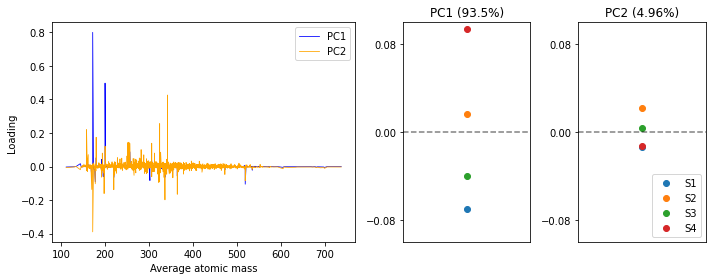

In [48]:
def loading_plot(loadingDF):
    """This function takes a loading dataframe and plots the loadings of the first 2 PCs against mass"""
    formula = list(loadingDF.index)
    pk.mass_spectrum(formula_list=formula, peak_intensities= loadingDF.iloc[:,0],method = 'average', normalise= False, color = 'b')
    pk.mass_spectrum(formula_list=formula, peak_intensities= loadingDF.iloc[:,1],method = 'average', normalise= False, color = 'orange')
    plt.ylabel('Loading')
    plt.legend(['PC1','PC2'])
    
    return plt.gcf(), plt.gca()

#Below we plot the loadings alongside the sample coordinates on the first two princial axis. 
#Masses with a positive loading in PC1 are correlated with samples with a positive value in PC1 etc.
group_names = ['S1','S2','S3','S4']
plt.figure(figsize=(10, 4)) # create the overall figure
plt.subplot(1,4,(1,2)) #take two panels of the subplot for the loading plot
loading_plot(loadingDF)
plt.subplot(1,4,3) #take one panel for the PC1 plot
for i in range(0,4):
    plt.scatter(0,pca_result[i,0]) #if you want to shudder the points (to avoid overlap) replace 0 with random.uniform(-.1,.1)
plt.title('PC1 (93.5%)')
plt.ylim(-.1,.1)
plt.xticks([])
plt.yticks([-.08,0,.08])
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)
plt.subplot(1,4,4) #take the final panel for the PC2 plot
for i in range(0,4):
    plt.scatter(0,pca_result[i,1]) 
plt.title('PC2 (4.96%)')
plt.ylim(-.1,.1)
plt.xticks([])
plt.yticks([-.08,0,.08])
plt.legend(group_names, loc = 'lower right')
plt.axhline(0, color='k', linestyle = '--', alpha = 0.5)

plt.tight_layout()
plt.show()

* Analysing the above graphic we can see that in the first principal component, that accounts for ~95% of variation in the dataset, sample 4 is separated from the other three samples and strongly correlated  with two masses, one at ~ 180 Da and one ~ 200 Da. Sample 1 and 2 have negative scores PC1 and are correlated with masses at ~ 300 Da and ~ 500 Da. The samples are more clustered in PC2 which accounts for ~ 5% of the overal variation in the dataset and there is a greater range of positive and negative loadings across masses from 100 - 400 Da.

**That's the end of the guide.** Hopefully you are now more comfortable using sklearn and PyKrev to perform dimensionality reduction on your FT-MS data. One of the main advantages of doing your data analysis in Python is being able to use the powerful machine learning libraries Python has to offer. sklearn has many capabilities beyond PCA - ... discriminant analysis, k-means clustering, neural networks, random forest classifiers and  support vector machines to name just a few -  that will enable you to ask new and interesting questions with your data. [ You can learn more about them here.](https://scikit-learn.org/stable/)
  * Contact : ezra.kitson@ed.ac.uk
  * Last Updated: 12/01/2021